## Import Lib

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn import svm
from sklearn.utils import resample

from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torch.nn.functional as F


from mmd import MMD_torch
from mmd import get_mmd_inds

## Load data form files

In [2]:
data = np.load("adult/adult_train.npz")
train_x = data['x']
train_y = data['y']
train_a = data['a']
print('train_x.shape',train_x.shape)
print('train_y.shape',train_y.shape)
print('train_a.shape',train_a.shape)

train_x.shape (32561, 113)
train_y.shape (32561, 1)
train_a.shape (32561, 1)


In [3]:
test_data = np.load("adult/adult_test.npz")
test_x = test_data['x']
test_y = test_data['y']
test_a = test_data['a']
print('test_x.shape',test_x.shape)
print('test_y.shape',test_y.shape)
print('test_a.shape',test_a.shape)

test_x.shape (16281, 113)
test_y.shape (16281, 1)
test_a.shape (16281, 1)


In [4]:
headers = pd.read_csv("adult/adult_headers.txt", sep=" ",header=None)
headers = np.array(headers)

## Create Data Frames

In [5]:
train_x_pd = pd.DataFrame(data = train_x, columns = headers[0:113,0], dtype='int')
train_y_pd = pd.DataFrame(data = train_y, columns = np.array(headers[113]), dtype='int')

test_x_pd = pd.DataFrame(data = test_x, columns = headers[0:113,0], dtype='int')
test_y_pd = pd.DataFrame(data = test_y, columns = np.array(headers[113]), dtype='int')

## Unbalance in data (income)

more thank 50k 7841
less thank 50k 24720


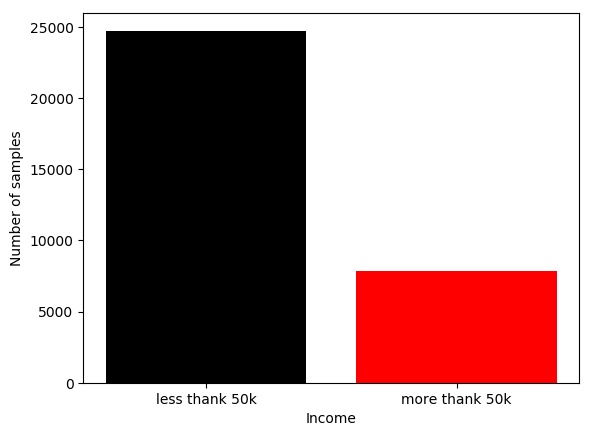

In [69]:
headers = headers.reshape(-1)

more_50k = np.count_nonzero(train_y)
less_50k = len(train_y)-np.count_nonzero(train_y)
print('more thank 50k',more_50k)
print('less thank 50k',less_50k)
plt.bar(['less thank 50k','more thank 50k'],[less_50k,more_50k] , color=['black', 'red'])
plt.xlabel("Income")
plt.ylabel("Number of samples")
# plt.savefig("income_hist",dpi= 600) #uncomment this i you want to save the image
plt.show()


## Unbalance in data (gender)

males 21790
females 10771


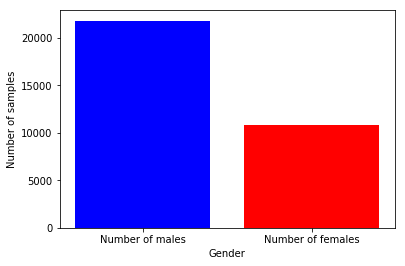

In [7]:
n_females = len(train_a)-np.count_nonzero(train_a)
n_males   = np.count_nonzero(train_a)

print('males',n_males)
print('females',n_females)

plt.bar(['Number of males','Number of females'],[n_males,n_females] ,color=['blue', 'red'] )
plt.xlabel("Gender")
plt.ylabel("Number of samples")
# plt.savefig("gender_hist",dpi= 600) #uncomment this i you want to save the image
plt.show()

## Accuracy Functions

$A$: Sensitive Attribute (in this example A= Gender)

$ \hat{Y}$: Classifier Prediction

$Y$: True label
- Accuracy (A):
    $$A = \frac{1}{n}  \sum_{i=1}^{n} 1 [ \hat{Y} = Y]$$
- Reweighted Accuracy (R):
    $$  R = \frac{1}{2} \bigg[ \frac{1}{n_{A}=0} \sum_{i=1}^{n} 1 [\hat{Y}=Y, A=0] +     \frac{1}{n_{A}=1} \sum_{i=1}^{n} 1 [\hat{Y}=Y, A=1] \bigg] $$
- Demographic Parity (DP) Accuracy:
    $$ DP = \bigg| \frac{1}{n_{A}=0} \sum_{i=1}^{n} \hat{Y}(1-A) - \frac{1}{n_{A}=1} \sum_{i=1}^{n} \hat{Y}(A) \bigg| 
   \label{DP_accuracy} $$


In [8]:
def accuracy (y,y_hat):
    count=0
    for i in range (len(y_hat)):
        if y[i] == y_hat[i]:
            count+=1
    accuracy= count/len(y_hat)*100
    print('accuracy={0:.2f}%'.format(accuracy))

In [9]:
def reweighted_accuracy (y,y_hat,A):
    count_A0 =0
    count_A1 =0
    n_A1 = np.count_nonzero(A)
    n_A0 = len(A) - np.count_nonzero(A)
    for i in range (len(y_hat)):
        if y[i] == y_hat[i]:
            if A[i] == 1:
                count_A1 +=1
            else:
                count_A0 +=1
    accuracy= 0.5* (count_A1/n_A1 + count_A0/n_A0) *100
    print('re-weighted accuracy={0:.2f}%'.format(accuracy))

In [10]:
def DP_accuracy (y_hat,A):
    A , y_hat = A.reshape(-1) , y_hat.reshape(-1)
    
    sum_A0 = 0
    sum_A1 = 0
    n_A1 = np.count_nonzero(A)
    n_A0 = len(A) - np.count_nonzero(A)
    for i in range (len(y_hat)):
        sum_A0 += y_hat[i]*(1-A[i])
        sum_A1 += y_hat[i]*A[i]
    accuracy= abs(sum_A0/n_A0 - sum_A1/n_A1)
    print('DP accuracy={0:.2f}'.format(accuracy))

In [11]:
def all_accuarcy_fun (y, y_hat , A):
    y, y_hat, A = np.array(y), np.array(y_hat), np.array(A)
    accuracy (y,y_hat)
    reweighted_accuracy (y,y_hat,A)
    DP_accuracy (y_hat,A)

# Part One: Classifier

# classifier Function (Logistic Regression, Random Forest, Linear SVM and SVC )

In [12]:
def classifier (train_x , train_y , test_x, test_y, test_a):
    
    print('############## Linear SVM #############')
    linear_svm = svm.LinearSVC(dual=False).fit(train_x, train_y.ravel())
    a_hat = linear_svm.predict(test_x)
    all_accuarcy_fun(test_y , a_hat , test_a)
    
    print('############## Logistic Regression #############')
    logistic_after_removing_A = LogisticRegression(solver='saga', max_iter=1000).fit(train_x, train_y.ravel())
    a_hat = logistic_after_removing_A.predict(test_x)
    all_accuarcy_fun(test_y , a_hat ,test_a)

    print('############## Random Forest #############')
    forest_feature_after_removing_A  = RandomForestClassifier(n_estimators=1000, max_depth=10).fit(train_x, train_y.ravel())
    a_hat = forest_feature_after_removing_A.predict(test_x)
    all_accuarcy_fun(test_y , a_hat ,test_a)

    print('############## SVC #############')
    svc = SVC(gamma='auto').fit(train_x, train_y.ravel())
    a_hat = svc.predict(test_x)
    all_accuarcy_fun(test_y , a_hat , test_a)

## Predict Y (income)

In [13]:
classifier(train_x, train_y, test_x, test_y , test_a)

############## Linear SVM #############
accuracy=85.65%
re-weighted accuracy=87.48%
DP accuracy=0.17
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=79.50%
re-weighted accuracy=81.92%
DP accuracy=0.04
############## Random Forest #############
accuracy=85.85%
re-weighted accuracy=87.67%
DP accuracy=0.15
############## SVC #############
accuracy=86.59%
re-weighted accuracy=88.29%
DP accuracy=0.16


## Predict A (Gender)

In [14]:
# removing sex_male and sex_female form training and testing data
train_x_without_A = np.delete(train_x,[66,67],1)
test_x_without_A = np.delete(test_x, [66,67] ,1)

classifier(train_x_without_A, train_a , test_x_without_A , test_a,  test_a)

############## Linear SVM #############
accuracy=84.18%
re-weighted accuracy=83.46%
DP accuracy=0.67
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00
############## Random Forest #############
accuracy=84.45%
re-weighted accuracy=81.85%
DP accuracy=0.64
############## SVC #############
accuracy=82.19%
re-weighted accuracy=81.71%
DP accuracy=0.63


# Pearsonr correlation function

In [15]:
def pearsonr_corr (train_x, train_y):
    corrl = []
    for j in range (train_x.shape[1]):
        corr, _ = pearsonr(train_y.reshape(-1), train_x[:,j])
        corrl.append(corr)
    corrl = abs(np.array(corrl))
    sorted_corrl = np.sort(corrl)[::-1][0:10]
    features_index = np.argsort(corrl)[::-1][0:10]
    print('################ top 10 features ################')
    for i in range (len(features_index)):
        print('No:{} {}'.format(i+1 , headers[features_index[i]]))
    return features_index , sorted_corrl

## TOP 10 important features for Y and A

In [16]:
print('------------------ Income ------------------')
top_10_featurese_y , sorted_corrl_y = pearsonr_corr (train_x, train_y)
print('------------------ Gender ------------------')
top_10_featurese_a, sorted_corrl_a  = pearsonr_corr (train_x_without_A, train_a)

------------------ Income ------------------
################ top 10 features ################
No:1 marital-status_Married-civ-spouse
No:2 relationship_Husband
No:3 education_num
No:4 marital-status_Never-married
No:5 age_u30
No:6 hours-per-week
No:7 relationship_Own-child
No:8 capital-gain
No:9 sex_Male
No:10 sex_Female
------------------ Gender ------------------
################ top 10 features ################
No:1 relationship_Husband
No:2 marital-status_Married-civ-spouse
No:3 relationship_Unmarried
No:4 relationship_Wife
No:5 occupation_Adm-clerical
No:6 capital-gain
No:7 marital-status_Divorced
No:8 occupation_Craft-repair
No:9 marital-status_Widowed
No:10 marital-status_Never-married


## Plot the most IMpoartace featuers

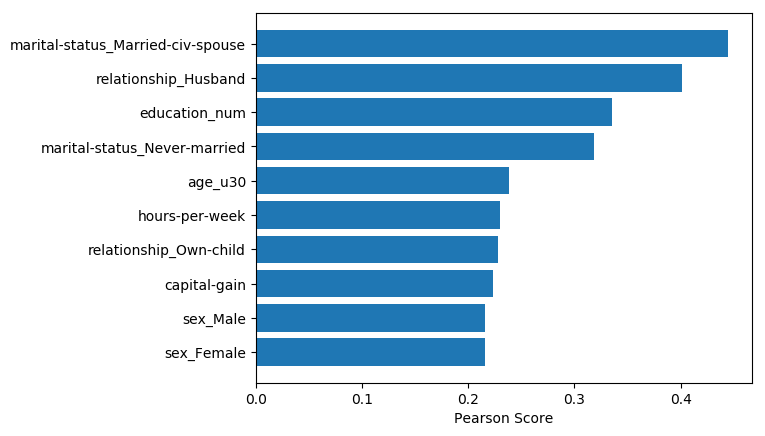

In [17]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(headers[top_10_featurese_y]))
ax.barh(y_pos, sorted_corrl_y, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(headers[top_10_featurese_y])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Pearson Score')
# plt.savefig("top_features_y",dpi= 600 , bbox_inches="tight")
plt.show()

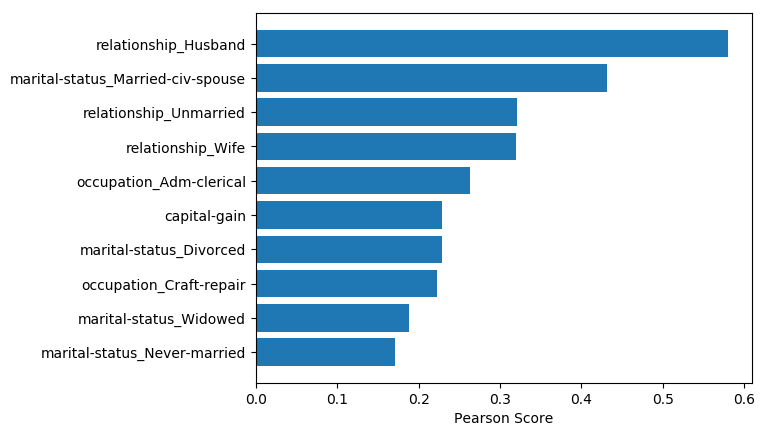

In [18]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(headers[top_10_featurese_a]))
ax.barh(y_pos, sorted_corrl_a, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(headers[top_10_featurese_a])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Pearson Score')
# plt.savefig("top_features_a",dpi= 600 , bbox_inches="tight")
plt.show()

## Train model after removing most importace features  

In [19]:
############### Remove importace features form the income #############
train_x_without_importace_y = np.delete(train_x,top_10_featurese_y,1)

test_x_without_importace_y = np.delete(test_x,top_10_featurese_y,1)
############### Remove importace features form the gender #############
train_x_without_importace_a = np.delete(train_x_without_A,top_10_featurese_a,1)
test_x_without_importace_a = np.delete(test_x_without_A,top_10_featurese_a,1)

print('------------------ Income ------------------')
classifier(train_x_without_importace_y, train_y , test_x_without_importace_y , test_y,  test_a)
print('------------------ Gender ------------------')
classifier(train_x_without_importace_a, train_a , test_x_without_importace_a , test_a,  test_a)

------------------ Income ------------------
############## Linear SVM #############
accuracy=83.38%
re-weighted accuracy=85.27%
DP accuracy=0.13
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=77.15%
re-weighted accuracy=80.12%
DP accuracy=0.02
############## Random Forest #############
accuracy=81.84%
re-weighted accuracy=84.22%
DP accuracy=0.07
############## SVC #############
accuracy=84.23%
re-weighted accuracy=86.09%
DP accuracy=0.13
------------------ Gender ------------------
############## Linear SVM #############
accuracy=69.76%
re-weighted accuracy=60.76%
DP accuracy=0.22
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00
############## Random Forest #############
accuracy=69.76%
re-weighted accuracy=56.50%
DP accuracy=0.13
############## SVC #############
accuracy=69.12%
re-weighted accuracy=57.92%
DP accuracy=0.16


## Train model with 3 corrilated features only

In [20]:
############### Remove importace features form the income #############
train_x_with_importace_y_olny = train_x[:,top_10_featurese_y[0:3]]
test_x_with_importace_y_only = test_x[:,top_10_featurese_y[0:3]]



############### Remove importace features form the gender #############
train_x_with_importace_a_only = train_x_without_A[:,top_10_featurese_a[0:3]]
test_x_with_importace_a_only = test_x_without_A[:,top_10_featurese_a[0:3]]



print('------------------ Income ------------------')
classifier(train_x_with_importace_y_olny, train_y , test_x_with_importace_y_only , test_y,  test_a)
print('------------------ Gender ------------------')
classifier(train_x_with_importace_a_only, train_a , test_x_with_importace_a_only , test_a,  test_a)

------------------ Income ------------------
############## Linear SVM #############
accuracy=82.34%
re-weighted accuracy=84.58%
DP accuracy=0.15
############## Logistic Regression #############
accuracy=82.34%
re-weighted accuracy=84.58%
DP accuracy=0.15
############## Random Forest #############
accuracy=82.21%
re-weighted accuracy=84.47%
DP accuracy=0.12
############## SVC #############
accuracy=82.21%
re-weighted accuracy=84.47%
DP accuracy=0.12
------------------ Gender ------------------
############## Linear SVM #############
accuracy=76.73%
re-weighted accuracy=67.20%
DP accuracy=0.34
############## Logistic Regression #############
accuracy=76.73%
re-weighted accuracy=67.20%
DP accuracy=0.34
############## Random Forest #############
accuracy=76.73%
re-weighted accuracy=67.20%
DP accuracy=0.34
############## SVC #############
accuracy=76.73%
re-weighted accuracy=67.20%
DP accuracy=0.34


# Using Trees to calculate correlation

## TOP 10 important features for Y and A

In [21]:
def tress_features (train_x, train_y):
    features = ExtraTreesClassifier(n_estimators=1000).fit(train_x, train_y.ravel())
    importance = np.array(features.feature_importances_)

    sorted_importance = np.sort(importance)[::-1]
    top_featurese_y = np.argsort(importance)[::-1]
    top_10_featurese_y = top_featurese_y[0:10]
    top_10_score_y = sorted_importance[0:10]
    features_10_names_y = []
    print('################ top 10 features ################')
    c=1
    for i in top_10_featurese_y:
        features_10_names_y.append(headers[i])
        print("No:{} {} P={:0.4f}".format(c,headers[i],top_10_score_y[c-1]))
        c+=1
    return top_10_featurese_y, top_10_score_y

In [22]:
print('------------------ Income ------------------')
top_10_featurese_y , top_10_score_y = tress_features (train_x, train_y)
print('------------------ Gender ------------------')
top_10_featurese_a , top_10_score_a = tress_features (train_x_without_A, train_a)

------------------ Income ------------------
################ top 10 features ################
No:1 hours-per-week P=0.1623
No:2 capital-gain P=0.0879
No:3 marital-status_Married-civ-spouse P=0.0785
No:4 relationship_Husband P=0.0528
No:5 education_num P=0.0420
No:6 marital-status_Never-married P=0.0319
No:7 capital-loss P=0.0314
No:8 occupation_Exec-managerial P=0.0285
No:9 age_u30 P=0.0271
No:10 occupation_Prof-specialty P=0.0240
------------------ Gender ------------------
################ top 10 features ################
No:1 relationship_Husband P=0.1803
No:2 capital-gain P=0.1199
No:3 relationship_Wife P=0.0831
No:4 marital-status_Married-civ-spouse P=0.0792
No:5 relationship_Unmarried P=0.0468
No:6 occupation_Craft-repair P=0.0351
No:7 occupation_Adm-clerical P=0.0348
No:8 marital-status_Never-married P=0.0222
No:9 relationship_Not-in-family P=0.0220
No:10 marital-status_Divorced P=0.0199


## Plot top Features A, Y

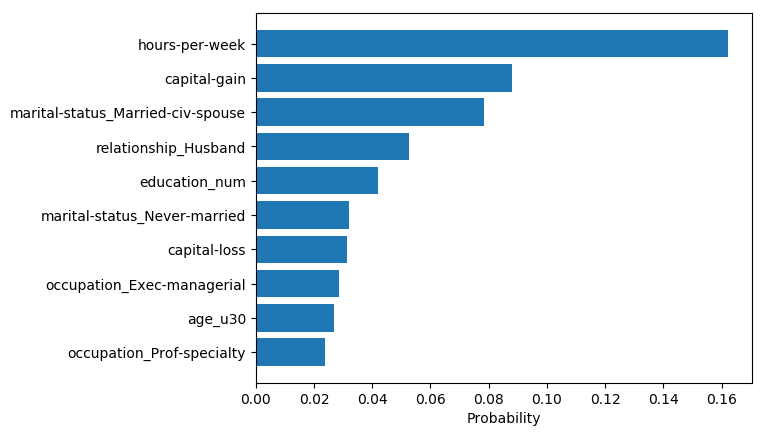

In [23]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(headers[top_10_featurese_y]))
ax.barh(y_pos, top_10_score_y, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(headers[top_10_featurese_y])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Probability')
plt.savefig("top_features_y_tress",dpi= 600 , bbox_inches="tight")
plt.show()

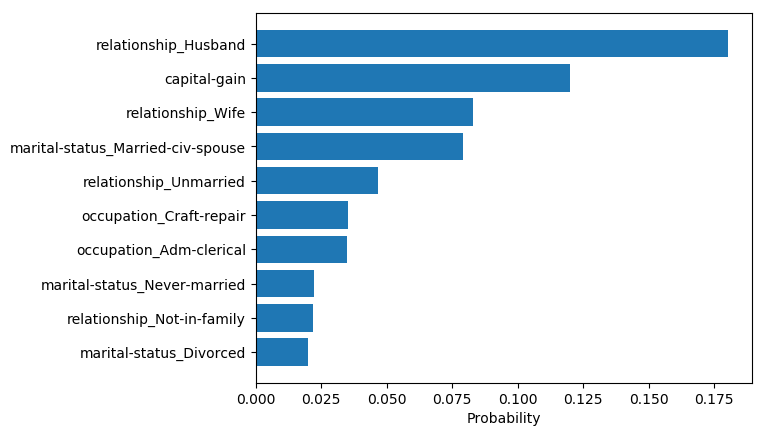

In [24]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(headers[top_10_featurese_a]))
ax.barh(y_pos, top_10_score_a, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(headers[top_10_featurese_a])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Probability')
plt.savefig("top_features_a_tress",dpi= 600 , bbox_inches="tight")
plt.show()

## Train model after removing most importace features  

In [25]:
############### Remove importace features form the income #############
train_x_without_importace_y = np.delete(train_x,top_10_featurese_y,1)
test_x_without_importace_y = np.delete(test_x,top_10_featurese_y,1)

############### Remove importace features form the gender #############
train_x_without_importace_a = np.delete(train_x_without_A,top_10_featurese_a,1)
test_x_without_importace_a = np.delete(test_x_without_A,top_10_featurese_a,1)

print('------------------ Income ------------------')
classifier(train_x_without_importace_y, train_y , test_x_without_importace_y , test_y,  test_a)
print('------------------ Gender ------------------')
classifier(train_x_without_importace_a, train_a , test_x_without_importace_a , test_a,  test_a)

------------------ Income ------------------
############## Linear SVM #############
accuracy=83.76%
re-weighted accuracy=85.70%
DP accuracy=0.17
############## Logistic Regression #############
accuracy=83.69%
re-weighted accuracy=85.66%
DP accuracy=0.18
############## Random Forest #############
accuracy=81.79%
re-weighted accuracy=83.99%
DP accuracy=0.11
############## SVC #############
accuracy=83.24%
re-weighted accuracy=85.33%
DP accuracy=0.17
------------------ Gender ------------------
############## Linear SVM #############
accuracy=70.87%
re-weighted accuracy=60.68%
DP accuracy=0.21
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00
############## Random Forest #############
accuracy=70.04%
re-weighted accuracy=56.41%
DP accuracy=0.13
############## SVC #############
accuracy=70.08%
re-weighted accuracy=58.32%
DP accuracy=0.17


## Train model with most importace features only

In [26]:
############### Remove importace features form the income #############
train_x_with_importace_y_olny = train_x[:,top_10_featurese_y]
test_x_with_importace_y_only = test_x[:,top_10_featurese_y]

############### Remove importace features form the gender #############
train_x_with_importace_a_only = train_x_without_A[:,top_10_featurese_a]
test_x_with_importace_a_only = test_x_without_A[:,top_10_featurese_a]


print('------------------ Income ------------------')
classifier(train_x_with_importace_y_olny, train_y , test_x_with_importace_y_only , test_y,  test_a)
print('------------------ Gender ------------------')
classifier(train_x_with_importace_a_only, train_a , test_x_with_importace_a_only , test_a,  test_a)

------------------ Income ------------------
############## Linear SVM #############
accuracy=84.77%
re-weighted accuracy=86.77%
DP accuracy=0.16
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=79.50%
re-weighted accuracy=81.92%
DP accuracy=0.04
############## Random Forest #############
accuracy=86.17%
re-weighted accuracy=87.97%
DP accuracy=0.15
############## SVC #############
accuracy=86.06%
re-weighted accuracy=87.78%
DP accuracy=0.16
------------------ Gender ------------------
############## Linear SVM #############
accuracy=81.78%
re-weighted accuracy=79.13%
DP accuracy=0.58
############## Logistic Regression #############
accuracy=81.76%
re-weighted accuracy=79.12%
DP accuracy=0.58
############## Random Forest #############
accuracy=81.87%
re-weighted accuracy=79.47%
DP accuracy=0.59
############## SVC #############
accuracy=81.79%
re-weighted accuracy=80.22%
DP accuracy=0.60


# Make data balanced by random down sampling

In [27]:
def down_sampling (x , y):

    training_all = np.concatenate((x,y), axis=1)

    ones_training = []
    zeros_training = []
    
    for i in range (len(y)):
        if training_all[i,-1] == 1:
            ones_training.append(training_all[i])
        else:
            zeros_training.append(training_all[i])
    
    ones_training , zeros_training = np.array(ones_training) , np.array(zeros_training)
 
    
    if ones_training.shape[0] < zeros_training.shape[0]:
        new_zeros_training = resample(zeros_training , n_samples = ones_training.shape[0])
        new_ones_training = ones_training
    else:
        new_ones_training = resample(ones_training , n_samples = zeros_training.shape[0])
        new_zeros_training = zeros_training
 
    
    new_training_all = np.concatenate((new_ones_training ,  new_zeros_training) , axis=0)
    
    np.random.shuffle(new_training_all)

    return new_training_all

less thank 50k 7841
more thank 50k 7841


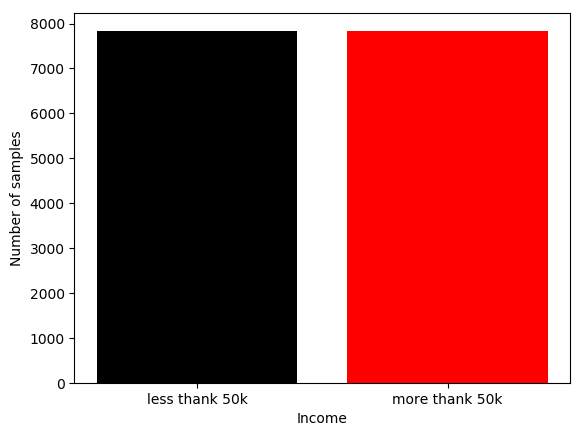

In [28]:
balanced_train_x_y = down_sampling (train_x,train_y)

# remove labels for income(Y)
balanced_train_y = balanced_train_x_y[:,-1]

balanced_train_x_y = np.delete(balanced_train_x_y, -1 ,axis= 1) 

#plot
less_50k = np.count_nonzero(balanced_train_y)
more_50k = len(balanced_train_y) - less_50k
print('less thank 50k',less_50k)
print('more thank 50k',more_50k)

plt.bar(['less thank 50k','more thank 50k'],[less_50k,more_50k] , color=['black', 'red'])
plt.xlabel("Income")
plt.ylabel("Number of samples")
# plt.savefig("income_hist_balanced",dpi= 600)
plt.show()

males 10771
females 10771


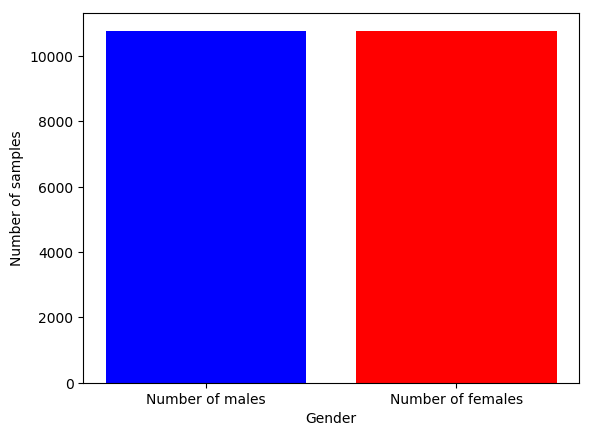

In [29]:
balanced_train_x_a = down_sampling(train_x_without_A , train_a)
# remove labels for sex (A)
balanced_train_a = balanced_train_x_a [:,-1]
balanced_train_x_a = np.delete(balanced_train_x_a, -1 , axis = 1)

#plot
n_males   = np.count_nonzero(balanced_train_a)
n_females = len(balanced_train_a) - n_males


print('males',n_males)
print('females',n_females)

plt.bar(['Number of males','Number of females'],[n_males,n_females] ,color=['blue', 'red'] )
plt.xlabel("Gender")
plt.ylabel("Number of samples")
# plt.savefig("gender_hist__balanced",dpi= 600)
plt.show()

## Predict Y (income) and A (Gender) after Down-sampling

In [30]:
print('------------------ Income ------------------')
classifier(balanced_train_x_y, balanced_train_y , test_x , test_y,  test_a)
print('------------------ Gender ------------------')
classifier(balanced_train_x_a, balanced_train_a , test_x_without_A , test_a,  test_a)

------------------ Income ------------------
############## Linear SVM #############
accuracy=78.61%
re-weighted accuracy=81.60%
DP accuracy=0.37
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=78.13%
re-weighted accuracy=80.38%
DP accuracy=0.05
############## Random Forest #############
accuracy=78.50%
re-weighted accuracy=81.59%
DP accuracy=0.39
############## SVC #############
accuracy=80.87%
re-weighted accuracy=83.55%
DP accuracy=0.36
------------------ Gender ------------------
############## Linear SVM #############
accuracy=82.20%
re-weighted accuracy=85.30%
DP accuracy=0.71
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=66.80%
re-weighted accuracy=50.24%
DP accuracy=0.00
############## Random Forest #############
accuracy=80.47%
re-weighted accuracy=84.85%
DP accuracy=0.70
############## SVC #############
accuracy=79.49%
re-weighted accuracy=82.44%
DP accuracy=0.65


## the Top features with Pearson

In [31]:
print('------------------ Income ------------------')
top_10_featurese_y , sorted_corrl_y = pearsonr_corr(balanced_train_x_y, balanced_train_y)
print('------------------ Gender ------------------')
top_10_featurese_a , sorted_corrl_a = pearsonr_corr(balanced_train_x_a, balanced_train_a)

------------------ Income ------------------
################ top 10 features ################
No:1 country_Holand-Netherlands
No:2 marital-status_Married-civ-spouse
No:3 relationship_Husband
No:4 marital-status_Never-married
No:5 education_num
No:6 relationship_Own-child
No:7 age_u30
No:8 sex_Male
No:9 sex_Female
No:10 hours-per-week
------------------ Gender ------------------
################ top 10 features ################
No:1 relationship_Husband
No:2 marital-status_Married-civ-spouse
No:3 relationship_Unmarried
No:4 relationship_Wife
No:5 occupation_Craft-repair
No:6 capital-gain
No:7 occupation_Adm-clerical
No:8 marital-status_Divorced
No:9 marital-status_Never-married
No:10 marital-status_Widowed


/home/montaser/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


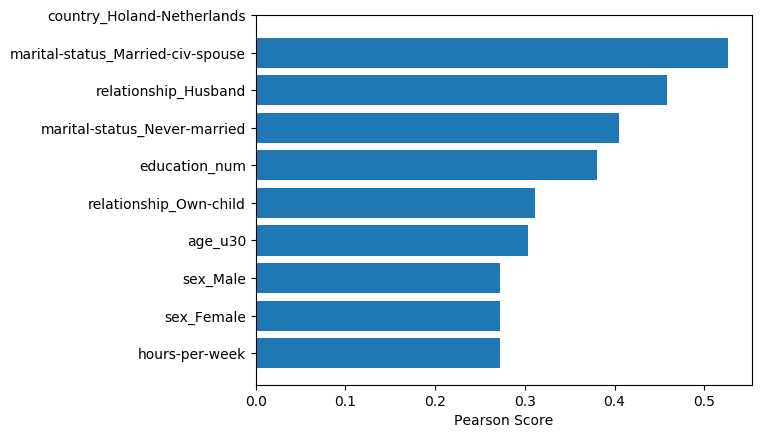

In [32]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(headers[top_10_featurese_y]))
ax.barh(y_pos, sorted_corrl_y, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(headers[top_10_featurese_y])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Pearson Score')
plt.savefig("balanced_top_features_y",dpi= 600 , bbox_inches="tight")
plt.show()

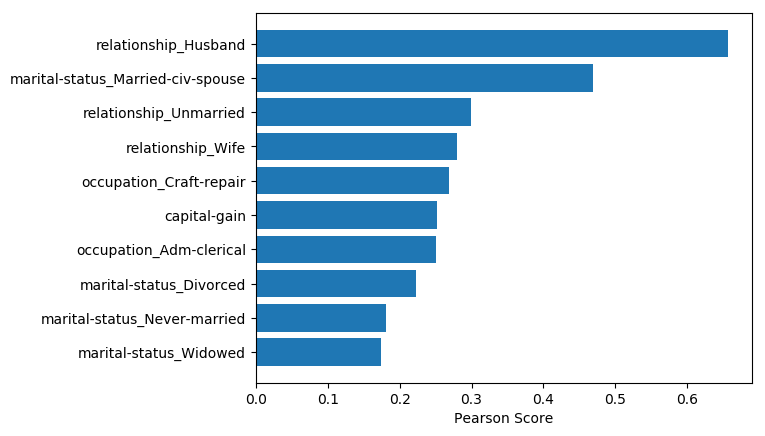

In [33]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(headers[top_10_featurese_a]))
ax.barh(y_pos, sorted_corrl_a, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(headers[top_10_featurese_a])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Pearson Score')
plt.savefig("balanced_top_features_a",dpi= 600 , bbox_inches="tight")
plt.show()

## Train model after removing most importace features  

In [34]:
############### Remove importace features form the income #############
train_x_without_importace_y = np.delete(balanced_train_x_y,top_10_featurese_y,1)
test_x_without_importace_y = np.delete(test_x,top_10_featurese_y,1)

############### Remove importace features form the gender #############
train_x_without_importace_a = np.delete(balanced_train_x_a,top_10_featurese_a,1)
test_x_without_importace_a = np.delete(test_x_without_A,top_10_featurese_a,1)
print('------------------ Income ------------------')
classifier(train_x_without_importace_y, balanced_train_y , test_x_without_importace_y , test_y,  test_a)
print('------------------ Gender ------------------')
classifier(train_x_without_importace_a, balanced_train_a , test_x_without_importace_a , test_a,  test_a)

------------------ Income ------------------
############## Linear SVM #############
accuracy=79.07%
re-weighted accuracy=80.95%
DP accuracy=0.26
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=78.12%
re-weighted accuracy=80.36%
DP accuracy=0.05
############## Random Forest #############
accuracy=79.73%
re-weighted accuracy=81.58%
DP accuracy=0.24
############## SVC #############
accuracy=81.65%
re-weighted accuracy=83.53%
DP accuracy=0.27
------------------ Gender ------------------
############## Linear SVM #############
accuracy=68.53%
re-weighted accuracy=69.33%
DP accuracy=0.39
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=39.98%
re-weighted accuracy=52.71%
DP accuracy=0.05
############## Random Forest #############
accuracy=69.30%
re-weighted accuracy=69.87%
DP accuracy=0.40
############## SVC #############
accuracy=68.88%
re-weighted accuracy=69.33%
DP accuracy=0.39


## Train model with most importace features only 

In [35]:
############### Remove importace features form the income #############
train_x_with_importace_y_olny = balanced_train_x_y[:,top_10_featurese_y]
test_x_with_importace_y_only = test_x[:,top_10_featurese_y]

############### Remove importace features form the gender #############
train_x_with_importace_a_only = balanced_train_x_a[:,top_10_featurese_a]
test_x_with_importace_a_only = test_x_without_A[:,top_10_featurese_a]
print('------------------ Income ------------------')
classifier(train_x_with_importace_y_olny, balanced_train_y , test_x_with_importace_y_only , test_y,  test_a)
print('------------------ Gender ------------------')
classifier(train_x_with_importace_a_only, balanced_train_a , test_x_with_importace_a_only , test_a,  test_a)

------------------ Income ------------------
############## Linear SVM #############
accuracy=76.85%
re-weighted accuracy=79.99%
DP accuracy=0.41
############## Logistic Regression #############
accuracy=77.20%
re-weighted accuracy=80.33%
DP accuracy=0.40
############## Random Forest #############
accuracy=76.91%
re-weighted accuracy=79.83%
DP accuracy=0.37
############## SVC #############
accuracy=77.31%
re-weighted accuracy=80.28%
DP accuracy=0.37
------------------ Gender ------------------
############## Linear SVM #############
accuracy=77.85%
re-weighted accuracy=82.69%
DP accuracy=0.65
############## Logistic Regression #############
accuracy=78.28%
re-weighted accuracy=82.51%
DP accuracy=0.65
############## Random Forest #############
accuracy=78.71%
re-weighted accuracy=82.54%
DP accuracy=0.65
############## SVC #############
accuracy=78.21%
re-weighted accuracy=82.11%
DP accuracy=0.64


## Top features with Tress

In [36]:
print('------------------ Income ------------------')
top_10_featurese_y , top_10_score_y = tress_features (balanced_train_x_y, balanced_train_y)
print('------------------ Gender ------------------')
top_10_featurese_a , top_10_score_a = tress_features (balanced_train_x_a, balanced_train_a)

------------------ Income ------------------
################ top 10 features ################
No:1 hours-per-week P=0.1351
No:2 marital-status_Married-civ-spouse P=0.0995
No:3 relationship_Husband P=0.0587
No:4 capital-gain P=0.0586
No:5 marital-status_Never-married P=0.0453
No:6 education_num P=0.0413
No:7 age_u30 P=0.0338
No:8 relationship_Own-child P=0.0242
No:9 occupation_Exec-managerial P=0.0220
No:10 capital-loss P=0.0217
------------------ Gender ------------------
################ top 10 features ################
No:1 relationship_Husband P=0.2151
No:2 capital-gain P=0.1030
No:3 marital-status_Married-civ-spouse P=0.0977
No:4 relationship_Wife P=0.0776
No:5 occupation_Craft-repair P=0.0422
No:6 relationship_Unmarried P=0.0377
No:7 occupation_Adm-clerical P=0.0270
No:8 marital-status_Never-married P=0.0213
No:9 marital-status_Divorced P=0.0203
No:10 relationship_Not-in-family P=0.0200


### Plot

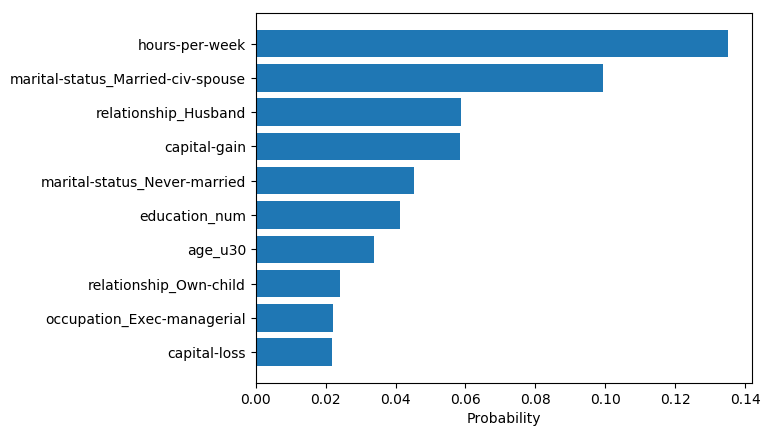

In [37]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(headers[top_10_featurese_y]))
ax.barh(y_pos, top_10_score_y, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(headers[top_10_featurese_y])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Probability')
plt.savefig("balanced_top_features_y_tress",dpi= 600 , bbox_inches="tight")
plt.show()

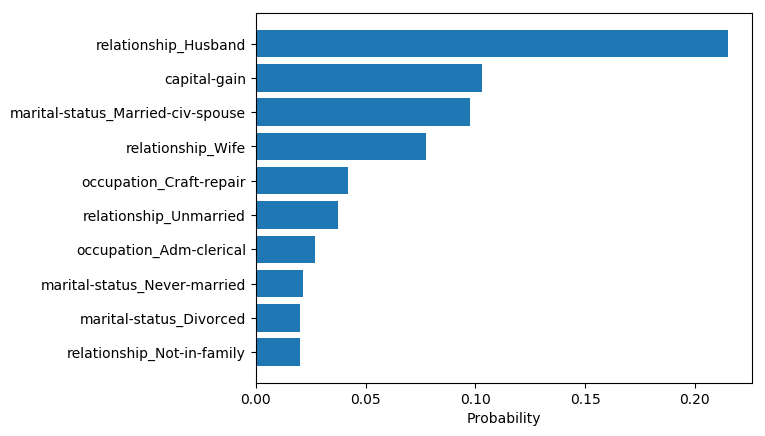

In [38]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(headers[top_10_featurese_a]))
ax.barh(y_pos, top_10_score_a, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(headers[top_10_featurese_a])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Probability')
plt.savefig("balanced_top_features_a_tress",dpi= 600 , bbox_inches="tight")
plt.show()

## Train model after removing most importace features  

In [39]:
############### Remove importace features form the income #############
train_x_without_importace_y = np.delete(balanced_train_x_y,top_10_featurese_y,1)
test_x_without_importace_y = np.delete(test_x,top_10_featurese_y,1)

############### Remove importace features form the gender #############
train_x_without_importace_a = np.delete(balanced_train_x_a,top_10_featurese_a,1)
test_x_without_importace_a = np.delete(test_x_without_A,top_10_featurese_a,1)
print('------------------ Income ------------------')
classifier(train_x_without_importace_y, balanced_train_y , test_x_without_importace_y , test_y,  test_a)
print('------------------ Gender ------------------')
classifier(train_x_without_importace_a, balanced_train_a , test_x_without_importace_a , test_a,  test_a)

------------------ Income ------------------
############## Linear SVM #############
accuracy=77.56%
re-weighted accuracy=80.49%
DP accuracy=0.37
############## Logistic Regression #############
accuracy=77.83%
re-weighted accuracy=80.70%
DP accuracy=0.36
############## Random Forest #############
accuracy=74.73%
re-weighted accuracy=78.62%
DP accuracy=0.45
############## SVC #############
accuracy=76.86%
re-weighted accuracy=80.03%
DP accuracy=0.40
------------------ Gender ------------------
############## Linear SVM #############
accuracy=67.09%
re-weighted accuracy=67.32%
DP accuracy=0.35
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=39.98%
re-weighted accuracy=52.71%
DP accuracy=0.05
############## Random Forest #############
accuracy=69.07%
re-weighted accuracy=67.64%
DP accuracy=0.35
############## SVC #############
accuracy=64.58%
re-weighted accuracy=67.08%
DP accuracy=0.34


## Train model with most importace features only

In [40]:
############### Remove importace features form the income #############
train_x_with_importace_y_olny = balanced_train_x_y[:,top_10_featurese_y]
test_x_with_importace_y_only = test_x[:,top_10_featurese_y]

############### Remove importace features form the gender #############
train_x_with_importace_a_only = balanced_train_x_a[:,top_10_featurese_a]
test_x_with_importace_a_only = test_x_without_A[:,top_10_featurese_a]
print('------------------ Income ------------------')
classifier(train_x_with_importace_y_olny, balanced_train_y , test_x_with_importace_y_only , test_y,  test_a)
print('------------------ Gender ------------------')
classifier(train_x_with_importace_a_only, balanced_train_a , test_x_with_importace_a_only , test_a,  test_a)

------------------ Income ------------------
############## Linear SVM #############
accuracy=73.31%
re-weighted accuracy=77.36%
DP accuracy=0.46
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=78.13%
re-weighted accuracy=80.38%
DP accuracy=0.05
############## Random Forest #############
accuracy=79.72%
re-weighted accuracy=82.30%
DP accuracy=0.34
############## SVC #############
accuracy=78.53%
re-weighted accuracy=81.01%
DP accuracy=0.34
------------------ Gender ------------------
############## Linear SVM #############
accuracy=77.88%
re-weighted accuracy=82.69%
DP accuracy=0.65
############## Logistic Regression #############
accuracy=78.04%
re-weighted accuracy=82.63%
DP accuracy=0.65
############## Random Forest #############
accuracy=78.51%
re-weighted accuracy=82.36%
DP accuracy=0.65
############## SVC #############
accuracy=78.24%
re-weighted accuracy=82.23%
DP accuracy=0.64


# Part Two: Representation Learning

In [41]:
def normalize_array (a):
       return (a - np.mean(a,axis=0))/np.std(a,axis=0)

def normalize_gender (x , a):

    ones_training = []
    zeros_training = []
    
    for i in range (len(a)):
        if x[i,-1] == 1:
            ones_training.append(x[i])
        else:
            zeros_training.append(x[i])
    
    ones_training , zeros_training = np.array(ones_training) , np.array(zeros_training)
 
        
    zeros_training = normalize_array(zeros_training)
    ones_training  =  normalize_array(ones_training)
    normalize_gender = np.concatenate((ones_training ,  zeros_training) , axis=0)
    normalize_gender = np.nan_to_num(normalize_gender) # Nans to zeros
    data = normalize_gender
    

    return data , a

In [42]:
train_normalize_gender , label_train_normalize_gender = normalize_gender (train_x_without_A, train_a)
classifier(train_normalize_gender, label_train_normalize_gender , test_x_without_A , test_a , test_a)

############## Linear SVM #############


/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


accuracy=37.74%
re-weighted accuracy=51.61%
DP accuracy=0.03
############## Logistic Regression #############


/home/montaser/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


accuracy=63.41%
re-weighted accuracy=48.59%
DP accuracy=0.03
############## Random Forest #############
accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00
############## SVC #############
accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00


# Use Neural Network as classifier

In [43]:
class model(nn.Module):
    def __init__(self,input_size,n_hidden):
        super(model, self).__init__()
        self.h1 = nn.Sequential(
        nn.Linear(input_size, int(input_size/2)),
        nn.ReLU(), 
        nn.Linear(int(input_size/2), int(input_size/4)),
        nn.ReLU(), 
        nn.Linear(int(input_size/4), int(input_size/8)),
        nn.ReLU(), 
        nn.Linear(int(input_size/8), n_hidden)
        ) 
        
        self.o = nn.Sequential( 
        nn.Linear(n_hidden,1) )
        
    def forward(self, x):
        x = self.h1(x)
        x = self.o(x)
        return x

In [44]:
batch_size = 512
input_size = 112
n_hidden = 20
lr = 1e-2
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr=lr)
train_losses = []
epoch = 0
num_of_epochs = 50

In [45]:
def train(epoch, train_model, train_in, train_t, train_optimizer):
    train_model.train()
    for data,target in zip(train_in.split(batch_size),train_t.split(batch_size)):
        output = train_model(data)
        loss = F.binary_cross_entropy_with_logits(output,target)
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()
    if(epoch%10 == 0):
        train_losses.append(loss.item())
        print("[EPOCH]: %i, [LOSS]: %.4f" % (epoch+1, loss.item()))
    return train_losses

In [46]:
def train_mmd (epoch, train_model, train_in, train_t, train_optimizer , alpha= 0.1):
    train_model.train()
    for data,target in zip(train_in.split(batch_size),train_t.split(batch_size)):
        output = train_model(data)
        loss = F.binary_cross_entropy_with_logits(output,target) + alpha*MMD_torch(train_model.h1(data) ,data[:,66] )
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()
    if(epoch%10 == 0):
        train_losses.append(loss.item())
        print("[EPOCH]: %i, [Binary LOSS]: %.4f , [Total LOSS]: %.4f" % (epoch+1, F.binary_cross_entropy_with_logits(output,target) , loss.item()))
    return train_losses

In [47]:
def train_mmd_a (epoch, train_model, train_in, train_t, train_optimizer , alpha= 0.1):
    train_model.train()
    for data,target in zip(train_in.split(batch_size),train_t.split(batch_size)):
        data = data[:,0:-1]
        output = train_model(data)
        loss = F.binary_cross_entropy_with_logits(output,target) + alpha*MMD_torch(train_model.h1(data) , target)
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()
    if(epoch%10 == 0):
        train_losses.append(loss.item())
        print("[EPOCH]: %i, [Binary LOSS]: %.4f , [Total LOSS]: %.4f" % (epoch+1, F.binary_cross_entropy_with_logits(output,target) , loss.item()))
    return train_losses

def test_fun_a(test_model, test_x, test_y, test_a):
    with torch.no_grad():
        test_model.eval()
        h_hat = test_model(test_x[:,0:-1])
        y_hat = np.zeros(len(test_y))
        for i in range (len(h_hat)):
            if torch.sigmoid(h_hat[i]) >= 0.5:
                y_hat [i] = 1
            else:
                y_hat [i] = 0
        all_accuarcy_fun ( test_y,  y_hat , test_a)

In [48]:
def test(test_model, test_x, test_y, test_a):
    with torch.no_grad():
        test_model.eval()
        h_hat = test_model(test_x)
        y_hat = np.zeros(len(test_y))
        for i in range (len(h_hat)):
            if torch.sigmoid(h_hat[i]) >= 0.5:
                y_hat [i] = 1
            else:
                y_hat [i] = 0
        all_accuarcy_fun ( test_y,  y_hat , test_a)

In [49]:
train_x_without_females = np.delete(train_x, 66, 1)
test_x_without_females = np.delete(test_x, 66, 1)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 2e-3)

## Predict Income (Y) 

### $\alpha=0.00$

In [50]:
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 2e-3)
for epoch in range(num_of_epochs):
    train_loss_binary = train(epoch, g_classifer, torch.tensor(train_x_without_females, dtype=torch.float), torch.tensor(train_y , dtype=torch.float), g_optimizer)
    
test(g_classifer, torch.tensor(test_x_without_females, dtype=torch.float), torch.tensor(test_y, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [LOSS]: 0.4677
[EPOCH]: 11, [LOSS]: 0.2806
[EPOCH]: 21, [LOSS]: 0.2634
[EPOCH]: 31, [LOSS]: 0.2522
[EPOCH]: 41, [LOSS]: 0.2484
accuracy=85.17%
re-weighted accuracy=86.97%
DP accuracy=0.20


### $\alpha=0.10$

In [52]:
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 2e-3)
for epoch in range(num_of_epochs):
    train_loss_01 = train_mmd(epoch, g_classifer, torch.tensor(train_x_without_females, dtype=torch.float), torch.tensor(train_y , dtype=torch.float), g_optimizer , alpha=0.1)
test(g_classifer, torch.tensor(test_x_without_females, dtype=torch.float), torch.tensor(test_y, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.4663 , [Total LOSS]: 0.4675
[EPOCH]: 11, [Binary LOSS]: 0.2679 , [Total LOSS]: 0.2706
[EPOCH]: 21, [Binary LOSS]: 0.2546 , [Total LOSS]: 0.2569
[EPOCH]: 31, [Binary LOSS]: 0.2461 , [Total LOSS]: 0.2483
[EPOCH]: 41, [Binary LOSS]: 0.2319 , [Total LOSS]: 0.2341
accuracy=85.03%
re-weighted accuracy=86.89%
DP accuracy=0.19


### $\alpha=0.20$

In [53]:
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 2e-3)
for epoch in range(num_of_epochs):
    train_loss_2 = train_mmd(epoch, g_classifer, torch.tensor(train_x_without_females, dtype=torch.float), torch.tensor(train_y , dtype=torch.float), g_optimizer , alpha=0.2)
test(g_classifer, torch.tensor(test_x_without_females, dtype=torch.float), torch.tensor(test_y, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.4780 , [Total LOSS]: 0.4799
[EPOCH]: 11, [Binary LOSS]: 0.2852 , [Total LOSS]: 0.2893
[EPOCH]: 21, [Binary LOSS]: 0.2736 , [Total LOSS]: 0.2777
[EPOCH]: 31, [Binary LOSS]: 0.2629 , [Total LOSS]: 0.2667
[EPOCH]: 41, [Binary LOSS]: 0.2508 , [Total LOSS]: 0.2542
accuracy=85.25%
re-weighted accuracy=87.08%
DP accuracy=0.20


### $\alpha=0.50$

In [54]:
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 2e-3)
for epoch in range(num_of_epochs):
    train_loss_5 = train_mmd(epoch, g_classifer, torch.tensor(train_x_without_females, dtype=torch.float), torch.tensor(train_y , dtype=torch.float), g_optimizer , alpha=0.5)
test(g_classifer, torch.tensor(test_x_without_females, dtype=torch.float), torch.tensor(test_y, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.4804 , [Total LOSS]: 0.4863
[EPOCH]: 11, [Binary LOSS]: 0.2732 , [Total LOSS]: 0.2815
[EPOCH]: 21, [Binary LOSS]: 0.2784 , [Total LOSS]: 0.2862
[EPOCH]: 31, [Binary LOSS]: 0.2622 , [Total LOSS]: 0.2700
[EPOCH]: 41, [Binary LOSS]: 0.2471 , [Total LOSS]: 0.2550
accuracy=85.31%
re-weighted accuracy=87.16%
DP accuracy=0.19


### $\alpha=0.70$

In [55]:
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 2e-3)
for epoch in range(num_of_epochs):
    train_loss_7 = train_mmd(epoch, g_classifer, torch.tensor(train_x_without_females, dtype=torch.float), torch.tensor(train_y , dtype=torch.float), g_optimizer , alpha=0.7)
test(g_classifer, torch.tensor(test_x_without_females, dtype=torch.float), torch.tensor(test_y, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.4874 , [Total LOSS]: 0.4953
[EPOCH]: 11, [Binary LOSS]: 0.2870 , [Total LOSS]: 0.2991
[EPOCH]: 21, [Binary LOSS]: 0.2660 , [Total LOSS]: 0.2772
[EPOCH]: 31, [Binary LOSS]: 0.2661 , [Total LOSS]: 0.2776
[EPOCH]: 41, [Binary LOSS]: 0.2564 , [Total LOSS]: 0.2680
accuracy=85.25%
re-weighted accuracy=87.02%
DP accuracy=0.18


### $\alpha=1.00$

In [51]:
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 2e-3)
for epoch in range(num_of_epochs):
    train_loss_1 = train_mmd(epoch, g_classifer, torch.tensor(train_x_without_females, dtype=torch.float), torch.tensor(train_y , dtype=torch.float), g_optimizer , alpha=1)
test(g_classifer, torch.tensor(test_x_without_females, dtype=torch.float), torch.tensor(test_y, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.4616 , [Total LOSS]: 0.4668
[EPOCH]: 11, [Binary LOSS]: 0.2878 , [Total LOSS]: 0.3033
[EPOCH]: 21, [Binary LOSS]: 0.2662 , [Total LOSS]: 0.2826
[EPOCH]: 31, [Binary LOSS]: 0.2537 , [Total LOSS]: 0.2690
[EPOCH]: 41, [Binary LOSS]: 0.2520 , [Total LOSS]: 0.2676
accuracy=85.31%
re-weighted accuracy=87.11%
DP accuracy=0.18


### $\alpha=10.00$

In [56]:
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 2e-3)
for epoch in range(num_of_epochs):
    train_loss_10 = train_mmd(epoch, g_classifer, torch.tensor(train_x_without_females, dtype=torch.float), torch.tensor(train_y , dtype=torch.float), g_optimizer , alpha=10.0)
test(g_classifer, torch.tensor(test_x_without_females, dtype=torch.float), torch.tensor(test_y, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.4981 , [Total LOSS]: 0.5780
[EPOCH]: 11, [Binary LOSS]: 0.3528 , [Total LOSS]: 0.4100
[EPOCH]: 21, [Binary LOSS]: 0.3141 , [Total LOSS]: 0.3827
[EPOCH]: 31, [Binary LOSS]: 0.3028 , [Total LOSS]: 0.3523
[EPOCH]: 41, [Binary LOSS]: 0.2967 , [Total LOSS]: 0.3526
accuracy=84.05%
re-weighted accuracy=85.63%
DP accuracy=0.06


### $\alpha=100.00$

In [57]:
g_classifer = model(input_size,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 2e-3)
for epoch in range(num_of_epochs):
    train_loss_10 = train_mmd(epoch, g_classifer, torch.tensor(train_x_without_females, dtype=torch.float), torch.tensor(train_y , dtype=torch.float), g_optimizer , alpha=100.0)
test(g_classifer, torch.tensor(test_x_without_females, dtype=torch.float), torch.tensor(test_y, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.5285 , [Total LOSS]: 0.9771
[EPOCH]: 11, [Binary LOSS]: 0.4607 , [Total LOSS]: 0.6592
[EPOCH]: 21, [Binary LOSS]: 0.5053 , [Total LOSS]: 0.6065
[EPOCH]: 31, [Binary LOSS]: 0.5055 , [Total LOSS]: 0.5938
[EPOCH]: 41, [Binary LOSS]: 0.5065 , [Total LOSS]: 0.6033
accuracy=76.57%
re-weighted accuracy=79.71%
DP accuracy=0.01


## Q:3.3 Predict Gender 

### $\alpha=0.00$

In [59]:
g_classifer = model(input_size-1,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 1e-1)
for epoch in range(num_of_epochs):
    train_loss_7 = train(epoch, g_classifer, torch.tensor(train_x_without_A, dtype=torch.float), torch.tensor(train_a , dtype=torch.float), g_optimizer)
test(g_classifer, torch.tensor(test_x_without_A, dtype=torch.float), torch.tensor(test_a, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [LOSS]: 0.3814
[EPOCH]: 11, [LOSS]: 0.3517
[EPOCH]: 21, [LOSS]: 0.3381
[EPOCH]: 31, [LOSS]: 0.3382
[EPOCH]: 41, [LOSS]: 0.3356
accuracy=82.65%
re-weighted accuracy=80.61%
DP accuracy=0.61


### $\alpha=0.10$

In [60]:
train_x_with_label = np.concatenate((train_x_without_A, train_a), axis=1)
test_x_with_label = np.concatenate((test_x_without_A, test_a), axis=1)

g_classifer = model(input_size-1,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 1e-1)
for epoch in range(num_of_epochs):
    train_loss_7 = train_mmd_a(epoch, g_classifer, torch.tensor(train_x_with_label, dtype=torch.float), torch.tensor(train_a , dtype=torch.float), g_optimizer, alpha=0.1)
test_fun_a(g_classifer, torch.tensor(test_x_with_label, dtype=torch.float), torch.tensor(test_a, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.6587 , [Total LOSS]: 0.6587
[EPOCH]: 11, [Binary LOSS]: 0.6533 , [Total LOSS]: 0.6533
[EPOCH]: 21, [Binary LOSS]: 0.6546 , [Total LOSS]: 0.6546
[EPOCH]: 31, [Binary LOSS]: 0.6461 , [Total LOSS]: 0.6461
[EPOCH]: 41, [Binary LOSS]: 0.6512 , [Total LOSS]: 0.6512
accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00


### $\alpha=0.20$

In [61]:
g_classifer = model(input_size-1,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 1e-1)
for epoch in range(num_of_epochs):
    train_loss_7 = train_mmd_a(epoch, g_classifer, torch.tensor(train_x_with_label, dtype=torch.float), torch.tensor(train_a , dtype=torch.float), g_optimizer, alpha=0.2)
test_fun_a(g_classifer, torch.tensor(test_x_with_label, dtype=torch.float), torch.tensor(test_a, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.6487 , [Total LOSS]: 0.6487
[EPOCH]: 11, [Binary LOSS]: 0.6463 , [Total LOSS]: 0.6463
[EPOCH]: 21, [Binary LOSS]: 0.6466 , [Total LOSS]: 0.6466
[EPOCH]: 31, [Binary LOSS]: 0.6497 , [Total LOSS]: 0.6497
[EPOCH]: 41, [Binary LOSS]: 0.6470 , [Total LOSS]: 0.6470
accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00


### $\alpha=0.50$

In [62]:
g_classifer = model(input_size-1,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(),  lr= 1e-1)
for epoch in range(num_of_epochs):
    train_loss_7 = train_mmd_a(epoch, g_classifer, torch.tensor(train_x_with_label, dtype=torch.float), torch.tensor(train_a , dtype=torch.float), g_optimizer, alpha=0.5)
test_fun_a(g_classifer, torch.tensor(test_x_with_label, dtype=torch.float), torch.tensor(test_a, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.6554 , [Total LOSS]: 0.6554
[EPOCH]: 11, [Binary LOSS]: 0.6585 , [Total LOSS]: 0.6585
[EPOCH]: 21, [Binary LOSS]: 0.6579 , [Total LOSS]: 0.6579
[EPOCH]: 31, [Binary LOSS]: 0.6557 , [Total LOSS]: 0.6557
[EPOCH]: 41, [Binary LOSS]: 0.6536 , [Total LOSS]: 0.6536
accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00


### $\alpha=0.70$

In [63]:
g_classifer = model(input_size-1,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 1e-1)
for epoch in range(num_of_epochs):
    train_loss_7 = train_mmd_a(epoch, g_classifer, torch.tensor(train_x_with_label, dtype=torch.float), torch.tensor(train_a , dtype=torch.float), g_optimizer, alpha=0.7)
test_fun_a(g_classifer, torch.tensor(test_x_with_label, dtype=torch.float), torch.tensor(test_a, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.6490 , [Total LOSS]: 0.6490
[EPOCH]: 11, [Binary LOSS]: 0.6467 , [Total LOSS]: 0.6467
[EPOCH]: 21, [Binary LOSS]: 0.6506 , [Total LOSS]: 0.6506
[EPOCH]: 31, [Binary LOSS]: 0.6469 , [Total LOSS]: 0.6469
[EPOCH]: 41, [Binary LOSS]: 0.6468 , [Total LOSS]: 0.6468
accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00


### $\alpha=1.00$

In [64]:
g_classifer = model(input_size-1,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 1e-1)
for epoch in range(num_of_epochs):
    train_loss_7 = train_mmd_a(epoch, g_classifer, torch.tensor(train_x_with_label, dtype=torch.float), torch.tensor(train_a , dtype=torch.float), g_optimizer, alpha=1.0)
test_fun_a(g_classifer, torch.tensor(test_x_with_label, dtype=torch.float), torch.tensor(test_a, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.6503 , [Total LOSS]: 0.6503
[EPOCH]: 11, [Binary LOSS]: 0.6467 , [Total LOSS]: 0.6467
[EPOCH]: 21, [Binary LOSS]: 0.6466 , [Total LOSS]: 0.6467
[EPOCH]: 31, [Binary LOSS]: 0.6475 , [Total LOSS]: 0.6475
[EPOCH]: 41, [Binary LOSS]: 0.6515 , [Total LOSS]: 0.6516
accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00


### $\alpha=10.00$

In [65]:
g_classifer = model(input_size-1,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 1e-1)
for epoch in range(num_of_epochs):
    train_loss_7 = train_mmd_a(epoch, g_classifer, torch.tensor(train_x_with_label, dtype=torch.float), torch.tensor(train_a , dtype=torch.float), g_optimizer, alpha=10.0)
test_fun_a(g_classifer, torch.tensor(test_x_with_label, dtype=torch.float), torch.tensor(test_a, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.6508 , [Total LOSS]: 0.6508
[EPOCH]: 11, [Binary LOSS]: 0.6462 , [Total LOSS]: 0.6462
[EPOCH]: 21, [Binary LOSS]: 0.6467 , [Total LOSS]: 0.6467
[EPOCH]: 31, [Binary LOSS]: 0.6489 , [Total LOSS]: 0.6489
[EPOCH]: 41, [Binary LOSS]: 0.6468 , [Total LOSS]: 0.6468
accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00


### $\alpha=100.00$

In [66]:
g_classifer = model(input_size-1,n_hidden)
g_optimizer = torch.optim.Adam(g_classifer.parameters(), lr= 1e-1)
for epoch in range(num_of_epochs):
    train_loss_7 = train_mmd_a(epoch, g_classifer, torch.tensor(train_x_with_label, dtype=torch.float), torch.tensor(train_a , dtype=torch.float), g_optimizer, alpha=100.0)
test_fun_a(g_classifer, torch.tensor(test_x_with_label, dtype=torch.float), torch.tensor(test_a, dtype=torch.float), torch.tensor(test_a, dtype=torch.float))

[EPOCH]: 1, [Binary LOSS]: 0.6519 , [Total LOSS]: 0.6519
[EPOCH]: 11, [Binary LOSS]: 0.6465 , [Total LOSS]: 0.6465
[EPOCH]: 21, [Binary LOSS]: 0.6483 , [Total LOSS]: 0.6483
[EPOCH]: 31, [Binary LOSS]: 0.6467 , [Total LOSS]: 0.6467
[EPOCH]: 41, [Binary LOSS]: 0.6469 , [Total LOSS]: 0.6469
accuracy=66.70%
re-weighted accuracy=50.00%
DP accuracy=0.00
